# Applied Deep Learning

##### Import the libraries and the dataset

In [34]:
import tensorflow as tf
import pandas as pd
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset
import keras_tuner as kt
import time
import seaborn as sns
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from scipy.ndimage import zoom
from sklearn.metrics import confusion_matrix

In [2]:
with open ('time_series_1.pickle', 'rb') as handle:
    time_series_1 = pickle.load(handle)
with open ('time_series_2.pickle', 'rb') as handle:
    time_series_2 = pickle.load(handle)
with open ('y.pickle', 'rb') as handle:
    y = pickle.load(handle)

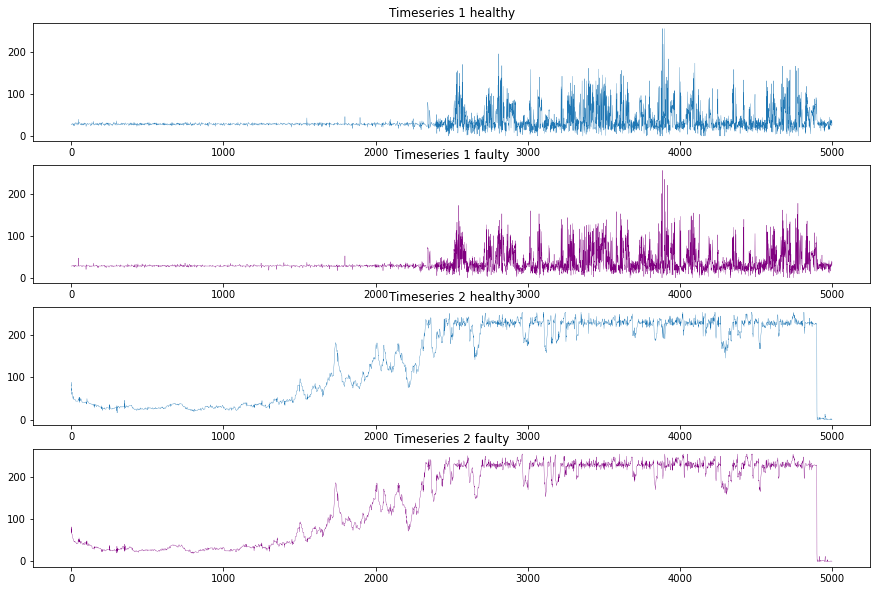

In [34]:
# Split the time series to healthy and faulty
time_series_1_h = np.where((y == 0))[0][0]
time_series_1_f = np.where((y == 3))[0][0]
time_series_2_h = np.where((y == 0))[0][0]
time_series_2_f = np.where((y == 3))[0][0]

# Plot the time series
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(411)
ax1.title.set_text("Timeseries 1 healthy",)
ax2 = fig.add_subplot(412)
ax2.title.set_text("Timeseries 1 faulty")
ax1.plot(time_series_1[time_series_1_h],linewidth=0.3)
ax2.plot(time_series_1[time_series_1_f],linewidth=0.3, color='purple')
ax3 = fig.add_subplot(413)
ax3.plot(time_series_2[time_series_2_h],linewidth=0.3)
ax3.title.set_text("Timeseries 2 healthy")
ax4 = fig.add_subplot(414)
ax4.plot(time_series_2[time_series_2_f],linewidth=0.3, color='purple')
ax4.title.set_text("Timeseries 2 faulty")

plt.show()

## Question 1:

Once we have reshaped and merged the two time series together, we can start building the training model for the prediction of the sensors. In this case, we have implemented different methods to try to find the model that could predict more accurately, using different RNN models and Conv1D. In this case, the type of approach in the RNN would be from sequence to vector, as we are delivering a classification task with a fixed length of output. Sequence to sequence, for instance, would be more suitable for uncertain output length.

In order to reduce the computational time, samples from the train and validation set were taken, 200 and 150, respectively, as reference of the whole sets to find the optimal model structure. Once selected the model design, we will implement keras tuner to the architecture to find the optimal hyperparamaters for the model, which will be applied to the entire training set and evaluated on validation set to classify and assess the accuracy. 

The same steps were followed for all the different methods. First of all we will try simple models with one layer then, adding layers up to three to avoid extensive computational time. From these three models, we will choose the one with the highest sampled validation accuracy and will try to add dropout and regularizer settings to see if the performance is improved. From all the trials, the architecture with the highest accuracy will be chosen to implement keras-tuner. In this case, the main hyperparameters to tune will be the number of units in each layer, the learning rate and the dropout or regularizer rate if applicable. 

Batch-normalization setting will not be tried in this situation, since it increases the training time significantly. However, if computational capacity is permitted, it could be added to the architecture to verify if it improves the prediction performance. Furthermore, we will not be adding activation functions to the models, except the 1D-Conv one, since it will lead to gradient decay over layers [1].

The following code is used to reshape the two time series arrays in order to combine them together as one to proceed with the implementation of the neural network architectures.

In [3]:
# Reshape the data to fit within RNN model
new_time_series_1 = time_series_1.reshape((4000,5000,1))
new_time_series_2 = time_series_2.reshape((4000,5000,1))
new_y = y.reshape((4000,1))

# The reshaped data which includes both time series
time_series_combined = np.dstack((new_time_series_1, new_time_series_2))

In [4]:
# Define the label of the data
class_names = ["Healthy", "Generator Faulty", "Pitch Faulty", "Both Faulty"]

In [5]:
# Split the data into training (70%), validation (15%), and test sets(15%)
X = time_series_combined
y= new_y
X_train, X_other, y_train,y_other = train_test_split(X,y, test_size=0.3, random_state=888)
X_valid, X_test, y_valid,y_test = train_test_split(X_other,y_other, test_size=0.5, random_state=888)

As mentioned previously, we sampled the train, validation and test data set to run the trial models. The same sample will be implemented across all the different approaches. 

In [6]:
# Sample the dataset to try different models
X_train_sample = X_train[:200,:,0:2]
X_valid_sample = X_valid[:150,:,0:2]
X_test_sample = X_test[:100,:,0:2]
y_train_sample = y_train[:200,:]
y_valid_sample = y_valid[:150,:]
y_test_sample = y_test[:100,:]

### 1. RNN models

The main settings for all the RNN trial models are:
- Number of units per layer: 20
- Learning rate: 0.001
- Optimizer: Adam
- Loss function: sparse categorical crossentropy, since we have a multiple classification task. 
- The early stopping callback was implemented, with patience 10. This means that if the loss of the model is not decreasing over 10 iterations, then the training process will be stopped automatically, which saves waiting time in case the model is not good enough.

The results obtained from the trials are:
1. Simple RNN with 1 layer: the accuracy on validation set was 0.36.
2. Two layers of RNN: the accuracy on validation set was 0.37. 
3. Three layer of RNN: the accuracy on validation set was 0.42. 

In this case, the model with 3 layers of RNN has a better performance on the sample validation set. From this basic model, we have tried to add different settings to see if the validation performance could be improved. But the result was that, the performance decreased. For instance, the same model with Dropout rate of 0.2, after each RNN layer, decreased the accuracy from 0.4 to 0.38. Therefore, we are going to select the Simple RNN model with 3 layers to the next step.


#### RNN Sample Trial

The trial process of the sample RNN model is detailed in the following cells.

In [10]:
model_rnn = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 2]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    Dense(4, activation='softmax')
])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          460       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 2,184
Trainable params: 2,184
Non-trainable params: 0
_________________________________________________________________


In [7]:
def train_plot(model_rnn, learning_rate = 0.001, epochs = 20):
    np.random.seed(888)
    tf.random.set_seed(888)

    model_rnn.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_rnn.fit(X_train_sample, y_train_sample, epochs=epochs,
                        validation_data=(X_valid_sample, y_valid_sample),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()
    
    return model_rnn

Epoch 1/20
7/7 [==============================] - 25s 3s/step - loss: 1.5875 - accuracy: 0.2450 - val_loss: 1.5369 - val_accuracy: 0.1867
Epoch 2/20
7/7 [==============================] - 24s 3s/step - loss: 1.4363 - accuracy: 0.2600 - val_loss: 1.4229 - val_accuracy: 0.1933
Epoch 3/20
7/7 [==============================] - 23s 3s/step - loss: 1.3954 - accuracy: 0.2600 - val_loss: 1.3822 - val_accuracy: 0.2600
Epoch 4/20
7/7 [==============================] - 24s 3s/step - loss: 1.3922 - accuracy: 0.3000 - val_loss: 1.3715 - val_accuracy: 0.3600
Epoch 5/20
7/7 [==============================] - 25s 4s/step - loss: 1.3874 - accuracy: 0.2700 - val_loss: 1.3673 - val_accuracy: 0.3400
Epoch 6/20
7/7 [==============================] - 23s 3s/step - loss: 1.3847 - accuracy: 0.2700 - val_loss: 1.3699 - val_accuracy: 0.3400
Epoch 7/20
7/7 [==============================] - 24s 3s/step - loss: 1.3867 - accuracy: 0.2650 - val_loss: 1.3769 - val_accuracy: 0.2533
Epoch 8/20
7/7 [==================

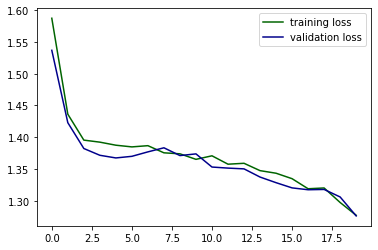

In [12]:
# Train the sample model
train_plot(model_rnn)

In [13]:
# Evaluate validation accuracy
model_rnn.evaluate(X_valid_sample, y_valid_sample)

5/5 [==============================] - 2s 341ms/step - loss: 1.2760 - accuracy: 0.4200


[1.2759984731674194, 0.41999998688697815]

After choosing the optimal architecture structure of the model, Keras Tuner will be implemented to find the optimal hyperparameters that could provide the highest accuracy. In this case, since the optimal structure chosen is a simple RNN, the tuned hyperparameters will only be the number of units in each layer, which is equal for all the layers, and the learning rate. 

The ranges established for the number of units is between 10 to 80, to keep the computational time under control, otherwise, the process of finding the optimal value will take too long. For the learning rate, we set the ranges between 0.001 to 0.01. 

In order to save computational time, the tuner process will also be implemented on the sampled set. The result obtained was an optimal learning rate of 0.002 and best number of units of 76 in each layer.

In [16]:
def train_model_RNN(hp):    
    num_units = hp.Int('num_units', min_value = 10, max_value=80) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=0.01, sampling='log') 
    
    model_RNN = tf.keras.models.Sequential([
        SimpleRNN(num_units, return_sequences=True, input_shape=[None,2]),
        SimpleRNN(num_units, return_sequences=True),
        SimpleRNN(num_units),
        Dense(4, activation='softmax')
        
    ])

            
    model_RNN.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    
    return model_RNN

In [17]:
tuner = kt.Hyperband(train_model_RNN,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='logs2',
                     project_name='RNN_tuning')
tuner.search(X_train_sample, y_train_sample, validation_data=(X_valid_sample,y_valid_sample))

Trial 30 Complete [00h 03m 57s]
val_accuracy: 0.3400000035762787

Best val_accuracy So Far: 0.4333333373069763
Total elapsed time: 00h 51m 42s
INFO:tensorflow:Oracle triggered exit


In [18]:
best_hps = tuner.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps['learning_rate']))
print("Best number of hidden units: " + str(best_hps['num_units']))

Best learning rate: 0.002117866325946303
Best number of hidden units: 76


#### RNN train model

The final step is to run the chosen architecture with the optimal hyperparameters to the whole training set. The callback setting was also applied in order to save computational time in case the model is not improving anymore. The number of epochs in the training process is 20, if computational capacity is allowed, this number could be increased, allowing the model to keep on training and learning, which might increase the classfication performance.

From the parameters chosen by keras-tuner and implemented to the chosen architecture, the final accuracy of the model on the validation set was 76%.

In [19]:
best_model_RNN = tuner.hypermodel.build(best_hps)

In [20]:
# Train the model with the best parameters
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
log_RNN = best_model_RNN.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])

Epoch 1/20
88/88 [==============================] - 314s 4s/step - loss: 1.2830 - accuracy: 0.3929 - val_loss: 1.1926 - val_accuracy: 0.4667
Epoch 2/20
88/88 [==============================] - 319s 4s/step - loss: 1.0464 - accuracy: 0.5457 - val_loss: 0.9239 - val_accuracy: 0.5917
Epoch 3/20
88/88 [==============================] - 323s 4s/step - loss: 0.8684 - accuracy: 0.6329 - val_loss: 0.8283 - val_accuracy: 0.6600
Epoch 4/20
88/88 [==============================] - 325s 4s/step - loss: 0.7374 - accuracy: 0.6871 - val_loss: 0.5774 - val_accuracy: 0.7850
Epoch 5/20
88/88 [==============================] - 309s 4s/step - loss: 0.6345 - accuracy: 0.7471 - val_loss: 0.6678 - val_accuracy: 0.7317
Epoch 6/20
88/88 [==============================] - 286s 3s/step - loss: 0.5871 - accuracy: 0.7736 - val_loss: 0.5731 - val_accuracy: 0.7750
Epoch 7/20
88/88 [==============================] - 284s 3s/step - loss: 0.6110 - accuracy: 0.7557 - val_loss: 0.6882 - val_accuracy: 0.7200
Epoch 8/20
88

In [36]:
# Evaluate validation accuracy
best_model_RNN.evaluate(X_valid, y_valid)

19/19 [==============================] - 10s 501ms/step - loss: 0.5639 - accuracy: 0.7600


[0.5639497637748718, 0.7599999904632568]

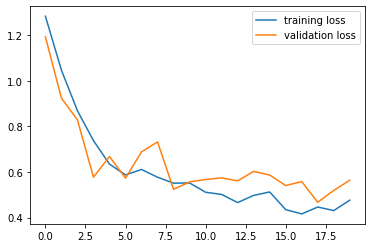

In [37]:
plt.plot(log_RNN.history['loss'],label = "training loss")
plt.plot(log_RNN.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

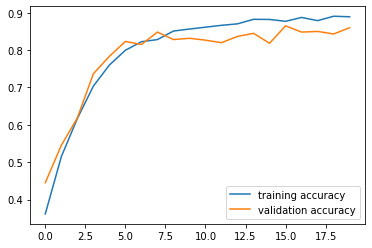

In [ ]:
plt.plot(log_RNN.history['accuracy'],label = "training accuracy")
plt.plot(log_RNN.history['val_accuracy'], label = "validation accuracy")
plt.legend()
plt.show()

### 2. LSTM models

The same process and settings of the sample models will be implemented to try LSTM models:
- Number of units per layer: 20
- Learning rate: 0.001
- Optimizer: Adam
- Loss function: sparse categorical crossentropy
- Early stopping callback of 10


#### LSTM Sample Trial

In this case, the results obtained from the trials are:
1. Simple LSTM with 1 layer: the accuracy on validation set was 0.3. 
2. Two layers of LSTM: the accuracy on validation set was 0.34.
3. Three layers of LSTM: the accuracy on validation set was 0.36.

According to the criteria of validation set, the model with 3 layers of LSTM is chosen. After adding new layers to the model, such as dropout and regularizers, the validation accuracy decreased to 0.34. Therefore, the same as RNN model, we will implement a simple LSTM model to the parameter tuning process.


In [ ]:
model_LSTM = Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, 2]),
    LSTM(20, return_sequences=True),
    LSTM(20),
    Dense(4, activation='softmax')
])
model_LSTM.summary()

In [ ]:
# Train the sample model
train_plot(model_LSTM)

In [ ]:
# Evaluate validation accuracy
model_LSTM.evaluate(X_valid_sample, y_valid_sample)

In this case, the parameters that will be tuned are the number of units in each layer, between 20 to 80, and the learning rate, between 0.001 to 0.01. The rest of the setting is maintained the same as in RNN model. 

In [ ]:
# Define the setting of the training model
def train_model_LSTM(hp):    
     num_units = hp.Int('num_units', min_value = 20, max_value=80) 
     learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=0.01, sampling='log') 
    
     model_lstm = tf.keras.models.Sequential([
         LSTM(num_units, return_sequences=True, input_shape=[None,2]),
         LSTM(num_units, return_sequences=True),
         LSTM(num_units),
         Dense(4, activation='softmax')
        
     ])

            
     model_lstm.compile(loss="sparse_categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   metrics=["accuracy"])

    
     return model_lstm

In [ ]:
tuner_lstm = kt.Hyperband(train_model_LSTM,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='logs2',
                     project_name='lstm_model')
tuner_lstm.search(X_train_sample, y_train_sample, validation_data=(X_valid_sample,y_valid_sample))

Trial 30 Complete [00h 00m 44s]
val_accuracy: 0.3400000035762787

Best val_accuracy So Far: 0.4000000059604645
Total elapsed time: 00h 11m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_lstm = tuner_lstm.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps_lstm['learning_rate']))
print("Best number of hidden units: " + str(best_hps_lstm['num_units']))

Best learning rate: 0.001018651170473196
Best number of hidden units: 60


#### LSTM train model

The optimal learning rate in this case is around 0.001 and the number of units in each layer is 60. By training 20 epochs, the validation accuracy of the LSTM model is around 77.5%. 

In [ ]:
best_model_lstm = tuner_lstm.hypermodel.build(best_hps_lstm)

In [ ]:
# Train the model with the optimal hyperparameters
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
log_lstm = best_model_lstm.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])

Epoch 1/20
88/88 [==============================] - 41s 419ms/step - loss: 1.3965 - accuracy: 0.2446 - val_loss: 1.3855 - val_accuracy: 0.2567
Epoch 2/20
88/88 [==============================] - 43s 495ms/step - loss: 1.3846 - accuracy: 0.2643 - val_loss: 1.3748 - val_accuracy: 0.2517
Epoch 3/20
88/88 [==============================] - 38s 428ms/step - loss: 1.3649 - accuracy: 0.3096 - val_loss: 1.3266 - val_accuracy: 0.3633
Epoch 4/20
88/88 [==============================] - 36s 409ms/step - loss: 1.3037 - accuracy: 0.3996 - val_loss: 1.2803 - val_accuracy: 0.3983
Epoch 5/20
88/88 [==============================] - 36s 414ms/step - loss: 1.2321 - accuracy: 0.4514 - val_loss: 1.1348 - val_accuracy: 0.4850
Epoch 6/20
88/88 [==============================] - 37s 418ms/step - loss: 1.0738 - accuracy: 0.5368 - val_loss: 1.0376 - val_accuracy: 0.5733
Epoch 7/20
88/88 [==============================] - 37s 426ms/step - loss: 0.9443 - accuracy: 0.5979 - val_loss: 0.9162 - val_accuracy: 0.6150

In [ ]:
# Evaluate validation accuracy
best_model_lstm.evaluate(X_valid, y_valid)

19/19 [==============================] - 3s 161ms/step - loss: 0.5913 - accuracy: 0.7750


[0.591282308101654, 0.7749999761581421]

### 3. GRU

#### GRU Sample Trial

As mentioned previously, for the trial models, the same settings were implemented and defined in the train_plot function. 

From the trial models, the results obtained were:
1. Simple GRU with 1 layer: the accuracy on the validation set was 0.32.
2. Two layers of GRU: the accuracy on the validation set was 0.34.
3. Three layers of GRU: the accuracy on the validation set was 0.32. 

The model with two layers of GRU performed better on the validation set, therefore we would choose this one for the parameter tuning process. Adding dropout layer was tried as well, which also decreased the accuracy rate. Hence, we would use a simple GRU model.

In [ ]:
model_GRU = Sequential([
    GRU(20, return_sequences=True, input_shape=[None, 2]),
    GRU(20),
    Dense(4, activation='softmax'),
])
model_GRU.summary()

In [ ]:
train_plot(model_GRU)

In [ ]:
# Evaluate validation accuracy
model_GRU.evaluate(X_valid_sample, y_valid_sample)

Since adding other layers could not improve the performance of the model, the same parameters mentioned before would be tuned to find the optimal values, the number of units per layer and the learning rate.

In [ ]:
def train_model_GRU(hp):    
     num_units = hp.Int('num_units', min_value = 20, max_value=80) 
     learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=0.01, sampling='log') 
    
     model_gru = tf.keras.models.Sequential([
         GRU(num_units, return_sequences=True, input_shape=[None,2]),
         GRU(num_units),
         Dense(4, activation='softmax')
        
     ])

            
     model_gru.compile(loss="sparse_categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   metrics=["accuracy"])

    
     return model_gru

In [ ]:
tuner_gru = kt.Hyperband(train_model_GRU,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='logs2',
                     project_name='gru_model')
tuner_gru.search(X_train_sample, y_train_sample, validation_data=(X_valid_sample,y_valid_sample))

Trial 30 Complete [00h 00m 27s]
val_accuracy: 0.3400000035762787

Best val_accuracy So Far: 0.4399999976158142
Total elapsed time: 00h 07m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_gru = tuner_gru.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps_gru['learning_rate']))
print("Best number of hidden units: " + str(best_hps_gru['num_units']))

Best learning rate: 0.003491600573827258
Best number of hidden units: 63


#### GRU train model

The best number of units per layer is 63 and the learning rate is 0.003, with a validation accuracy of around 82.83%. 

In [ ]:
best_model_gru = tuner_gru.hypermodel.build(best_hps_gru)

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
log_gru = best_model_gru.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])

Epoch 1/20
88/88 [==============================] - 27s 277ms/step - loss: 1.3457 - accuracy: 0.3489 - val_loss: 1.2701 - val_accuracy: 0.3633
Epoch 2/20
88/88 [==============================] - 24s 268ms/step - loss: 1.1605 - accuracy: 0.4736 - val_loss: 1.1218 - val_accuracy: 0.5000
Epoch 3/20
88/88 [==============================] - 23s 267ms/step - loss: 0.9742 - accuracy: 0.5693 - val_loss: 0.9349 - val_accuracy: 0.5883
Epoch 4/20
88/88 [==============================] - 23s 267ms/step - loss: 0.8202 - accuracy: 0.6468 - val_loss: 0.7647 - val_accuracy: 0.6583
Epoch 5/20
88/88 [==============================] - 23s 267ms/step - loss: 0.6772 - accuracy: 0.7268 - val_loss: 0.6463 - val_accuracy: 0.7200
Epoch 6/20
88/88 [==============================] - 24s 268ms/step - loss: 0.6039 - accuracy: 0.7554 - val_loss: 0.5518 - val_accuracy: 0.7700
Epoch 7/20
88/88 [==============================] - 24s 268ms/step - loss: 0.5344 - accuracy: 0.7825 - val_loss: 0.6659 - val_accuracy: 0.7083

In [ ]:
# Evaluate validation accuracy
best_model_gru.evaluate(X_valid, y_valid)

19/19 [==============================] - 2s 111ms/step - loss: 0.4411 - accuracy: 0.8283


[0.4410562217235565, 0.82833331823349]

### 4. 1D Conv + 2 GRU

The last model tried was a 1-Dimension Convolutional Neural Network architecture, combined with the different models implemented previously. The same process was followed as mentioned, where we tried to combine 1D CNN with one layer of RNN, LSTM or GRU and compare the validation accuracy of the sample set. 

#### 1D CNN Sample Trial

The same settings were implemented for all the models, with 20 number of units per layer and a learning rate of 0.001, using Adam optimizer and sparse categorical crossentropy loss function, running through 20 epochs.

The results obtained were:
1. 1D-CNN with 1 layer of RNN: the accuracy on validation set was 0.34.
2. 1D-CNN with 1 layer of LSTM: the accuracy on validation set was 0.379.
3. 1D-CNN with 1 layer of GRU: the accuracy on validation set was 0.45.

We also tried to implement two layers of each model, to verify if the performance would improve:

4. 1D-CNN with 2 layers of RNN: 0.37 of accuracy.
5. 1D-CNN with 2 layers of LSTM: 0.4 of accuracy.
6. 1D-CNN with 2 layers of GRU: 0.46 of accuracy. 


In this case, we would choose sample trial 6, 1D-CNN with 2 layers of GRU to the tuning process.

In [8]:
model_1Conv = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2], activation='relu'),
    GRU(20, return_sequences=True,input_shape=[None, 2]),
    GRU(20),
    Dense(4, activation='softmax'),
])
model_1Conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 gru (GRU)                   (None, None, 20)          2520      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 5,304
Trainable params: 5,304
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
7/7 [==============================] - 9s 352ms/step - loss: 1.4061 - accuracy: 0.2500 - val_loss: 1.3729 - val_accuracy: 0.2200
Epoch 2/20
7/7 [==============================] - 2s 245ms/step - loss: 1.3754 - accuracy: 0.2550 - val_loss: 1.3675 - val_accuracy: 0.2600
Epoch 3/20
7/7 [==============================] - 2s 245ms/step - loss: 1.3602 - accuracy: 0.3000 - val_loss: 1.3561 - val_accuracy: 0.2867
Epoch 4/20
7/7 [==============================] - 2s 246ms/step - loss: 1.3467 - accuracy: 0.3200 - val_loss: 1.3366 - val_accuracy: 0.4200
Epoch 5/20
7/7 [==============================] - 2s 246ms/step - loss: 1.3395 - accuracy: 0.3650 - val_loss: 1.3371 - val_accuracy: 0.4333
Epoch 6/20
7/7 [==============================] - 2s 236ms/step - loss: 1.3202 - accuracy: 0.4150 - val_loss: 1.3351 - val_accuracy: 0.3667
Epoch 7/20
7/7 [==============================] - 2s 249ms/step - loss: 1.3213 - accuracy: 0.3800 - val_loss: 1.3326 - val_accuracy: 0.3000
Epoch 8/20
7/7 [====

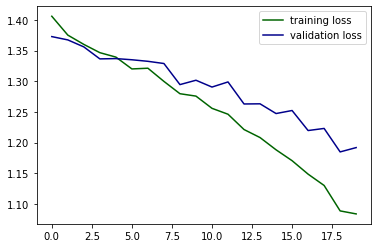

In [9]:
train_plot(model_1Conv)

In [10]:
# Evaluate validation accuracy
model_1Conv.evaluate(X_valid_sample, y_valid_sample)

5/5 [==============================] - 1s 91ms/step - loss: 1.1919 - accuracy: 0.4933


[1.191920518875122, 0.4933333396911621]

In [11]:
# clear TensorFlow session 
tf.keras.backend.clear_session()
np.random.seed(888)
tf.random.set_seed(888)

#### 1D-CNN train model

The following codes correspond to the parameter tuning process of the model selected previously. The same setting will be implemented, which will tune the number of units per layer and the learning rate of the model. 

The best learning rate in this case is 0.002 and the number of units per layer is 50. Training the model with these parameters in 20 epochs, gave an accuracy of 83.83% in the validation set. 

In [ ]:
def train_model_1DConv(hp):    
     num_units = hp.Int('num_units', min_value = 20, max_value=80) 
     learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=0.01, sampling='log') 
    
     model_1dconv = tf.keras.models.Sequential([
         Conv1D(filters=num_units, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2], activation='relu'),                                       
         GRU(num_units, return_sequences=True, input_shape=[None,2]),
         GRU(num_units),
         Dense(4, activation='softmax')
        
     ])

            
     model_1dconv.compile(loss="sparse_categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   metrics=["accuracy"])

    
     return model_1dconv



In [ ]:
tuner_1dconv = kt.Hyperband(train_model_1DConv,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='logs2',
                     project_name='1dconv_model')
tuner_1dconv.search(X_train_sample, y_train_sample, validation_data=(X_valid_sample,y_valid_sample))

INFO:tensorflow:Reloading Oracle from existing project logs2/1dconv_model/oracle.json
INFO:tensorflow:Reloading Tuner from logs2/1dconv_model/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_1dconv = tuner_1dconv.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps_1dconv['learning_rate']))
print("Best number of hidden units: " + str(best_hps_1dconv['num_units']))

Best learning rate: 0.0021209446304344343
Best number of hidden units: 50


In [ ]:
best_model_1dconv = tuner_1dconv.hypermodel.build(best_hps_1dconv)

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
log_1dconv = best_model_1dconv.fit(X_train, y_train, epochs=20,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])

Epoch 1/20
88/88 [==============================] - 16s 156ms/step - loss: 1.2583 - accuracy: 0.4089 - val_loss: 1.0215 - val_accuracy: 0.5650
Epoch 2/20
88/88 [==============================] - 13s 142ms/step - loss: 0.8642 - accuracy: 0.6289 - val_loss: 0.8635 - val_accuracy: 0.6350
Epoch 3/20
88/88 [==============================] - 12s 139ms/step - loss: 0.6645 - accuracy: 0.7268 - val_loss: 0.6263 - val_accuracy: 0.7183
Epoch 4/20
88/88 [==============================] - 12s 140ms/step - loss: 0.5052 - accuracy: 0.7986 - val_loss: 0.5759 - val_accuracy: 0.7667
Epoch 5/20
88/88 [==============================] - 12s 140ms/step - loss: 0.4165 - accuracy: 0.8346 - val_loss: 0.4539 - val_accuracy: 0.8033
Epoch 6/20
88/88 [==============================] - 12s 141ms/step - loss: 0.3834 - accuracy: 0.8493 - val_loss: 0.3773 - val_accuracy: 0.8650
Epoch 7/20
88/88 [==============================] - 12s 141ms/step - loss: 0.3507 - accuracy: 0.8579 - val_loss: 0.3903 - val_accuracy: 0.8567

In [ ]:
# Evaluate validation accuracy
best_model_1dconv.evaluate(X_valid, y_valid)

19/19 [==============================] - 1s 61ms/step - loss: 0.3633 - accuracy: 0.8383


[0.3633386790752411, 0.8383333086967468]

After implementing all the architectures from Recurrent Neural Network, the one that performed the best in our dataset was the Simple GRU with 2 layers, which provided an accuracy of 82.83% in the validation set. But if we design a more complex neural network, we can achieve more than 83% of accuracy by combining 1D-CNN with 2 layers of GRU. 

# Question 2:

 In this case, CNN would perform better than RNN when predicting time series data mainly because the time series data presents harshly variations, which are difficult to identify through human eyes the faulty status of the turbines. Therefore, once we have changed the data into images, the pixels would represent each time step, from which could identify the anomal status of the turbine in a easier way. 

 Furthermore, the prediction of whether the turbine is healthy or not would not highly be dependent to the first record of the turbine, but on the general pattern of performace of it over time. In this case, CNN would perform better extracting the patterns within a time period as it can see the data in a broader perspective compared to RNN. 

# Question 3:

In order to implement CNN models, it is essential that the data is in format of images. In this case, the reshape of both time series data into a single image of dimension 100x100x1 will be proceeded in the following steps.

In [16]:
# Reshape the data to fit within CNN model
new_time_series_1 = time_series_1.reshape((4000,100,50,1))
new_time_series_2 = time_series_2.reshape((4000,100,50,1))
time_series_image=np.concatenate((new_time_series_1,new_time_series_2),axis=2)

In [17]:
time_series_image[1].shape

(100, 100, 1)

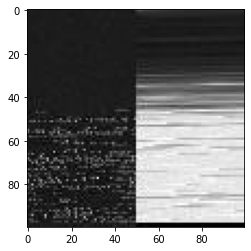

In [18]:
plt.imshow(time_series_image[1], cmap = 'gray')

# Question 4:

In this section, we are going to replicate the model CNN3-32 that is shown in the paper “Convolutional neural network fault classification based on time series analysis for benchmark wind turbine machine” and applied to our dataset to classify. 

In this case, the same compile settings were implemented as the previous models. The accuracy performance of the model CNN3-32 is of around 90%.

In [48]:
# Split the data into training (70%), validation (15%), and test sets(15%)
X = time_series_image
y= new_y
X_train, X_other, y_train,y_other = train_test_split(X,y, test_size=0.3, random_state=888)
X_valid, X_test, y_valid,y_test = train_test_split(X_other,y_other, test_size=0.5, random_state=888)

In [49]:
def train_cnn_model(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(888)
    tf.random.set_seed(888)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log_cnn = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log_cnn.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log_cnn.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()
    
    return model

In [50]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(100,100,1)),
    Conv2D(32, (3, 3), padding='valid',activation='relu'),
    Dropout(0.2),
    Conv2D(16, (3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(4, activation='softmax')
])

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 dropout_5 (Dropout)         (None, 96, 96, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 94, 94, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 15376)             0         
                                                      

Epoch 1/20
88/88 [==============================] - 2s 17ms/step - loss: 7.0092 - accuracy: 0.3986 - val_loss: 0.4733 - val_accuracy: 0.8567
Epoch 2/20
88/88 [==============================] - 1s 14ms/step - loss: 0.3808 - accuracy: 0.8646 - val_loss: 0.2935 - val_accuracy: 0.9067
Epoch 3/20
88/88 [==============================] - 1s 14ms/step - loss: 0.2899 - accuracy: 0.8796 - val_loss: 0.2305 - val_accuracy: 0.8933
Epoch 4/20
88/88 [==============================] - 1s 14ms/step - loss: 0.2756 - accuracy: 0.8875 - val_loss: 0.2272 - val_accuracy: 0.8967
Epoch 5/20
88/88 [==============================] - 1s 13ms/step - loss: 0.2609 - accuracy: 0.8882 - val_loss: 0.2433 - val_accuracy: 0.9050
Epoch 6/20
88/88 [==============================] - 1s 14ms/step - loss: 0.2650 - accuracy: 0.8854 - val_loss: 0.2410 - val_accuracy: 0.8967
Epoch 7/20
88/88 [==============================] - 1s 14ms/step - loss: 0.2486 - accuracy: 0.8889 - val_loss: 0.2154 - val_accuracy: 0.9083
Epoch 8/20
88

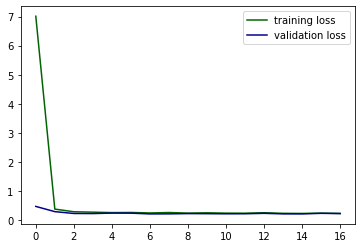

In [51]:
train_cnn_model(model_cnn)

In [52]:
# Evaluate validation accuracy
model_cnn.evaluate(X_valid, y_valid)

19/19 [==============================] - 0s 12ms/step - loss: 0.2154 - accuracy: 0.9083


[0.2153828889131546, 0.9083333611488342]

## Question 5:

The main objective of this section is to try to improve the performance of the CNN3-32 model replicated from the paper mentioned in the previous section.

In this case, different approaches have been selected to design different models:

1. Modifying the CNN in terms of the number of filters, kernel size and convolutional layers, as well as adding different types of layout, such as dropout, max pooling, batch normalization,among others. 

2. Include pre-trained models in the design of the model, both training and not training the layers of the pre-trained model.

3. We have tried applying Independent Component Analysis (ICA) to the dataset to identify the underlying sources and proceed the prediction from them. However, the prediction accuracy was lower than CNN3-32.

4. We have also tried using Autoencoder to classify, by training healthy turbines to identify the faulty ones, such as the case of Insurance Fraud project proceeded previously. But the model was not able to identify accurately the faulty ones. 



After trying different models and approaches, we could not obtain any model that could outperform the CNN3-32. We only managed to design one model, CNN3-128, which could achieve the same accuracy level of around 90%.

In this case, if computational capabilities is allowed, the accuracy could be improved by adding more number of units in each layer, as well as increasing the number of layers and the number of epochs in the training process, so that the model can learn enough patterns from the dataset to enhance its classification performance. In case of using CNN for prediction, adding Dropout layers would be helpful for the prediction accuracy, since it prevents from overfitting. For further exploration, there are other available methods that could be implemented in this situation, such as recursive neural networks.

In this case, just some of the trial models with decent accuracy level will be explained in details below. 

### Improve the CNN model

##### CNN2- 128

The first try of improvement is by increasing the number of units per layer and the number of layers in the model. 

The architecture of the model is:
- Five convolutional layers with different number of filters: 128, 64, 64, 32 and 16, respectively. 
- All the convolutional layers have a kernel size of 3x3 and a relu activation function.
- For the first convolutional layer, padding was added with stride of 2 to the border of the images so that information from the corner pixels could also be considered.
- Dropout layer of 0.2 (20%). 
- Maxpooling layer of size 2x2. 

After the last convolutional layer, the images were flatten and went through the output layer with softmax activation function of 4 neurons, since we have 4 possible outcomes of classification.

The rest of the parameters were maintained, with sparse categorical crossentropy loss function, Adam optimizer and a learning rate of 0.001. The early stopping callback was also set to 10 and the training model will run through 20 epochs. 

After training the model to the entire training set and evaluating on validation set, the accuracy performance was around 89%.


In [ ]:
def train_cnn_model2(model, learning_rate = 0.001, epochs = 20):
    # clear TensorFlow session 
    tf.keras.backend.clear_session()
    np.random.seed(888)
    tf.random.set_seed(888)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log_cnn2 = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log_cnn2.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log_cnn2.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()
    
    return model

In [ ]:
model_cnn2 = Sequential([
    Conv2D(128, (3, 3), padding='same',strides=(2,2), activation='relu', input_shape=(100,100,1)),
    Conv2D(64, (3, 3), padding='valid',activation='relu'),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='valid',activation='relu'),
    Conv2D(32, (3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), padding='valid', activation='relu'),
    Flatten(),
    Dense(4, activation='softmax')
])

model_cnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 128)       1280      
                                                                 
 dropout (Dropout)           (None, 98, 98, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        73792     
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 94, 94, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0

Epoch 1/20
88/88 [==============================] - 8s 86ms/step - loss: 1.9688 - accuracy: 0.2539 - val_loss: 1.3863 - val_accuracy: 0.2567
Epoch 2/20
88/88 [==============================] - 7s 82ms/step - loss: 1.3864 - accuracy: 0.2418 - val_loss: 1.3864 - val_accuracy: 0.2367
Epoch 3/20
88/88 [==============================] - 7s 85ms/step - loss: 1.3864 - accuracy: 0.2561 - val_loss: 1.3864 - val_accuracy: 0.2367
Epoch 4/20
88/88 [==============================] - 7s 82ms/step - loss: 1.3863 - accuracy: 0.2554 - val_loss: 1.3864 - val_accuracy: 0.2367
Epoch 5/20
88/88 [==============================] - 7s 82ms/step - loss: 1.3246 - accuracy: 0.3221 - val_loss: 1.0188 - val_accuracy: 0.6017
Epoch 6/20
88/88 [==============================] - 7s 83ms/step - loss: 0.5410 - accuracy: 0.7993 - val_loss: 0.2533 - val_accuracy: 0.8983
Epoch 7/20
88/88 [==============================] - 7s 85ms/step - loss: 0.2982 - accuracy: 0.8793 - val_loss: 0.2461 - val_accuracy: 0.9050
Epoch 8/20
88

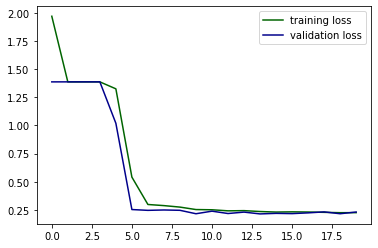

In [ ]:
train_cnn_model2(model_cnn2)

In [ ]:
# Evaluate validation accuracy
model_cnn2.evaluate(X_valid, y_valid)

19/19 [==============================] - 0s 24ms/step - loss: 0.2314 - accuracy: 0.8900


[0.23135310411453247, 0.8899999856948853]

##### CNN3-128

The next trial model is still a CNN, however, we made some modifications to the  design of the model compared to the previous one.

The structure of the model is:
- 4 convolutional layers with different filter numbers: 128, 64, 32 and 16, respectively. The kernel size is still 3x3 and with relu activation function.
- There is no padding in the first convolutional layer, compared to the previous model. 
- There is one dropout layer of 20%.
- There is a Maxpooling layer of 3x3 before flattening the images.
- The output layer has 4 neurons, with softmax activation function.

The compile settings of the model are the same as the previous one in order to make fair comparisons between the performance of the models. 

After runnning the model to the entire training set and evaluating on the validation set, the accuracy of prediction was 90.83%.




In [ ]:
def train_cnn_model3(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(888)
    tf.random.set_seed(888)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log_cnn3 = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log_cnn3.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log_cnn3.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    plt.show()
    
    return model

In [ ]:
model_cnn3 = Sequential([
    Conv2D(128, (3, 3), padding='valid', activation='relu', input_shape=(100,100,1)),
    Conv2D(64, (3, 3), padding='valid',activation='relu'),
    Dropout(0.2),
    Conv2D(32, (3, 3), padding='valid', activation='relu'),
    Conv2D(16, (3, 3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(4, activation='softmax')
])

model_cnn3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        73792     
                                                                 
 dropout (Dropout)           (None, 96, 96, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                        

Epoch 1/20
88/88 [==============================] - 6s 63ms/step - loss: 3.7431 - accuracy: 0.3343 - val_loss: 0.9240 - val_accuracy: 0.6967
Epoch 2/20
88/88 [==============================] - 5s 60ms/step - loss: 0.4668 - accuracy: 0.8321 - val_loss: 0.2480 - val_accuracy: 0.9017
Epoch 3/20
88/88 [==============================] - 5s 61ms/step - loss: 0.2972 - accuracy: 0.8721 - val_loss: 0.2273 - val_accuracy: 0.9083
Epoch 4/20
88/88 [==============================] - 5s 60ms/step - loss: 0.2819 - accuracy: 0.8857 - val_loss: 0.2548 - val_accuracy: 0.8200
Epoch 5/20
88/88 [==============================] - 5s 61ms/step - loss: 0.2599 - accuracy: 0.8818 - val_loss: 0.2231 - val_accuracy: 0.9083
Epoch 6/20
88/88 [==============================] - 5s 61ms/step - loss: 0.2570 - accuracy: 0.8850 - val_loss: 0.2180 - val_accuracy: 0.9033
Epoch 7/20
88/88 [==============================] - 5s 61ms/step - loss: 0.2419 - accuracy: 0.8914 - val_loss: 0.2169 - val_accuracy: 0.9033
Epoch 8/20
88

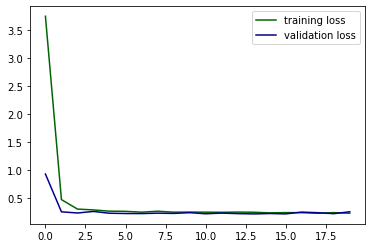

In [ ]:
train_cnn_model3(model_cnn3)

In [ ]:
# Evaluate validation accuracy
model_cnn3.evaluate(X_valid, y_valid)

19/19 [==============================] - 0s 5ms/step - loss: 0.2118 - accuracy: 0.9083


[0.21178828179836273, 0.9083333611488342]

More trials were made on CNN models, but the ones that performed better are the ones showed above. Furthermore, batchnormalization layers were added to the models as well however, the accuracy decreased to around 74%.

##### Combining MobileNet

The next trial to improve the classification model is combining pre-trained model, such as MobileNet to the architecture. 

Before implementing the pre-trained model, the input size of the images should be reshape according to the requirements of the model. In this case, we will change the size of image (100x100x1) to 160x160x3, which will be showed in detail below. 

In [20]:
x_preprocess_train = preprocess_input(X_train.copy())
x_preprocess_valid = preprocess_input(X_valid.copy())
x_preprocess_test = preprocess_input(X_test.copy())
x_preprocess_train.shape, x_preprocess_test.shape, x_preprocess_valid.shape

((2800, 100, 100, 1), (600, 100, 100, 1), (600, 100, 100, 1))

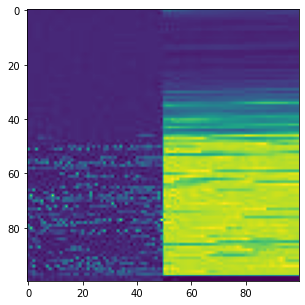

In [21]:
plt.figure(figsize=(5, 5))
plt.imshow((x_preprocess_train[0] + 1.0) * 127.5 / 255)
plt.show()

In [22]:
# Reshape the size of the images to fit within MobileNet
print('Processing training data')
resized_images = []
for i in range(x_preprocess_train.shape[0]):
    resized_images.append(zoom(x_preprocess_train[i], (1.6, 1.6, 3.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_train = np.stack(resized_images)

print('Processing validation data')
resized_images = []
for i in range(x_preprocess_valid.shape[0]):
    resized_images.append(zoom(x_preprocess_valid[i], (1.6, 1.6, 3.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_valid = np.stack(resized_images)

print('Processing testing data')
resized_images = []
for i in range(x_preprocess_test.shape[0]):
    resized_images.append(zoom(x_preprocess_test[i], (1.6, 1.6, 3.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_test = np.stack(resized_images)

x_preprocess_train.shape, x_preprocess_test.shape

Processing training data
* Processed 200 images
* Processed 400 images
* Processed 600 images
* Processed 800 images
* Processed 1000 images
* Processed 1200 images
* Processed 1400 images
* Processed 1600 images
* Processed 1800 images
* Processed 2000 images
* Processed 2200 images
* Processed 2400 images
* Processed 2600 images
* Processed 2800 images
Processing validation data
* Processed 200 images
* Processed 400 images
* Processed 600 images
Processing testing data
* Processed 200 images
* Processed 400 images
* Processed 600 images


((2800, 160, 160, 3), (600, 160, 160, 3))

In [23]:
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (160,160,3))
mobilenet.trainable = False
mobilenet.summary()

Model: "mobilenet_1.00_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 80, 80, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 80, 80, 32)       128       
 ation)                                         

Several different designs were tried with MobileNet:

1. We started by implementing a more simple model with MobileNet pre-trained layers, adding a global average pooling and a dense layer of 64 neurons with relu activation function. The accuracy of the model was 85%. 

2. Afterwards, a more complex model was built with convolutional layers of 32 filters with kernel size of 3x3, dropout layer and maxpooling layer of 3x3. Once flatten, there was one more dense layer of 16 neurons with relu activation function. The accuracy of the model was around 85%. 

3. The one with the highest accuracy is the one showed below. The main structure of the model is:

- MobileNet layer
- Global average pooling layer
- 2 dense layers of 64 and 32 neurons, respectively, with relu activation function. 
- Two dropout layers of 20%. 
- Output layer of 4 neurons with softmax activation function.

    The loss function used is still the sparse categorical crossentropy and the Adam optimizer with 0.001 of learning rate. The model will run through 20 epochs with a batch size of 128. The accuracy of the model on validation set is around 88%. 



In [24]:
# clear TensorFlow session 
tf.keras.backend.clear_session()

In [27]:
model_mobile = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])
model_mobile.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model_mobile.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [28]:
log_mobile= model_mobile.fit(x_preprocess_train, y_train,
           batch_size=128,
           epochs=20)

Epoch 1/20
22/22 [==============================] - 4s 74ms/step - loss: 1.4014 - accuracy: 0.3168
Epoch 2/20
22/22 [==============================] - 1s 54ms/step - loss: 1.2851 - accuracy: 0.4268
Epoch 3/20
22/22 [==============================] - 1s 54ms/step - loss: 1.1847 - accuracy: 0.4950
Epoch 4/20
22/22 [==============================] - 1s 53ms/step - loss: 1.0910 - accuracy: 0.5393
Epoch 5/20
22/22 [==============================] - 1s 54ms/step - loss: 0.9917 - accuracy: 0.6032
Epoch 6/20
22/22 [==============================] - 1s 53ms/step - loss: 0.8899 - accuracy: 0.6450
Epoch 7/20
22/22 [==============================] - 1s 53ms/step - loss: 0.8021 - accuracy: 0.7050
Epoch 8/20
22/22 [==============================] - 1s 54ms/step - loss: 0.7609 - accuracy: 0.6982
Epoch 9/20
22/22 [==============================] - 1s 53ms/step - loss: 0.7043 - accuracy: 0.7421
Epoch 10/20
22/22 [==============================] - 1s 54ms/step - loss: 0.6486 - accuracy: 0.7571
Epoch 11/

In [29]:
# Evaluate validation accuracy
model_mobile.evaluate(x_preprocess_valid, y_valid)

19/19 [==============================] - 1s 27ms/step - loss: 0.3173 - accuracy: 0.8850


[0.31733760237693787, 0.8849999904632568]

##### Partially train MobileNet

We have also tried on partially training MobileNet with the model 2 mentioned in previous section, which performed well without training MobileNet, to verify if it would enhance the accuracy. 

In this case, we unfreezed the last three layers of the model and set it to trainable, the rest of the layers are kept untrained.  However, the results were not good, the accuracy decreased to around 69% on validation set.

In [30]:
mobilenet.trainable = False
# Freeze layers in the base model except the last three layers
for layer in mobilenet.layers[:-3]:
    layer.trainable = True

In [36]:
model_mobile2 = Sequential([
    mobilenet,
    Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(100,100,1)),
    Dropout(0.2),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])

model_mobile2.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model_mobile2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          294944    
                                                                 
 dropout_3 (Dropout)         (None, 3, 3, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)               

In [37]:
log_mobile2= model_mobile2.fit(x_preprocess_train, y_train,
           batch_size=128,
           epochs=20)

Epoch 1/20
22/22 [==============================] - 3s 62ms/step - loss: 2.3051 - accuracy: 0.3686
Epoch 2/20
22/22 [==============================] - 1s 59ms/step - loss: 0.7752 - accuracy: 0.6750
Epoch 3/20
22/22 [==============================] - 1s 59ms/step - loss: 0.4537 - accuracy: 0.8289
Epoch 4/20
22/22 [==============================] - 1s 60ms/step - loss: 0.3672 - accuracy: 0.8600
Epoch 5/20
22/22 [==============================] - 1s 60ms/step - loss: 0.2999 - accuracy: 0.8939
Epoch 6/20
22/22 [==============================] - 1s 59ms/step - loss: 0.2626 - accuracy: 0.9057
Epoch 7/20
22/22 [==============================] - 1s 60ms/step - loss: 0.2300 - accuracy: 0.9189
Epoch 8/20
22/22 [==============================] - 1s 60ms/step - loss: 0.2004 - accuracy: 0.9271
Epoch 9/20
22/22 [==============================] - 1s 60ms/step - loss: 0.1785 - accuracy: 0.9336
Epoch 10/20
22/22 [==============================] - 1s 60ms/step - loss: 0.1566 - accuracy: 0.9443
Epoch 11/

In [38]:
# Evaluate validation accuracy
model_mobile2.evaluate(x_preprocess_valid, y_valid)

19/19 [==============================] - 1s 18ms/step - loss: 0.8166 - accuracy: 0.6933


[0.816613495349884, 0.6933333277702332]

# Question 6

After all the different trial of models, the optimal model is CNN3-32, the one from the research paper. Despite of having created a model that could perform the same level of accuracy than CNN3-32, the model was more complex, with more layers and number of neurons in each layer, which increases the training time. Therefore, after balancing both the accuracy and the training time, we have decided to select CNN3-32 to proceed the prediction on the test set. 

In this case, the same settings will be implemented on the CNN3-32 training model, which gave an accuracy of around 90% on the test set. From the confusion matrix plot below, we can see that a significant number of turbine that are healthy were classified as faulty. 

In [71]:
# Split the data into training (85%) and test sets(15%)
X = time_series_image
y= new_y
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.15, random_state=888)

In [72]:
def train_cnn(model, learning_rate = 0.001, epochs = 20):
    # clear TensorFlow session 
    tf.keras.backend.clear_session()
    np.random.seed(888)
    tf.random.set_seed(888)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    # early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log_cnn = model.fit(X_train, y_train, epochs=epochs)
    
    plt.plot(log_cnn.history['loss'],label = "training loss",color='darkgreen')
    plt.legend()
    ax = plt.gca()
    plt.show()
    
    return model

Epoch 1/20
107/107 [==============================] - 2s 13ms/step - loss: 0.1548 - accuracy: 0.9350
Epoch 2/20
107/107 [==============================] - 1s 13ms/step - loss: 0.1380 - accuracy: 0.9421
Epoch 3/20
107/107 [==============================] - 1s 12ms/step - loss: 0.1427 - accuracy: 0.9424
Epoch 4/20
107/107 [==============================] - 1s 13ms/step - loss: 0.1260 - accuracy: 0.9426
Epoch 5/20
107/107 [==============================] - 1s 12ms/step - loss: 0.1196 - accuracy: 0.9465
Epoch 6/20
107/107 [==============================] - 1s 12ms/step - loss: 0.1279 - accuracy: 0.9429
Epoch 7/20
107/107 [==============================] - 1s 12ms/step - loss: 0.1088 - accuracy: 0.9506
Epoch 8/20
107/107 [==============================] - 1s 12ms/step - loss: 0.1257 - accuracy: 0.9435
Epoch 9/20
107/107 [==============================] - 1s 13ms/step - loss: 0.1136 - accuracy: 0.9471
Epoch 10/20
107/107 [==============================] - 1s 12ms/step - loss: 0.1098 - accura

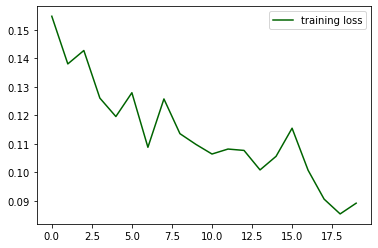

In [73]:
train_cnn(model_cnn)

In [ ]:
# save model_cnn.h5 file
# model_cnn.save("model_cnn6.h5")
# load the model
model_cnn= tf.keras.models.load_model("model_cnn6.h5")

In [74]:
# Evaluate test accuracy
model_cnn.evaluate(X_test, y_test)

19/19 [==============================] - 1s 19ms/step - loss: 0.1985 - accuracy: 0.9083


[0.19845913350582123, 0.9083333611488342]

In [75]:
# Predict the model with test set
y_pred = np.argmax(model_cnn.predict(X_test), axis=-1)
y_pred_label = [class_names[y] for y in y_pred]

In [78]:
# Plot confusion matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          title=None):


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap="Blues",cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

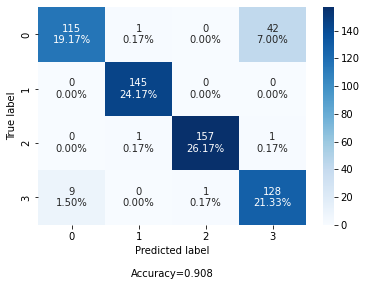

In [82]:
# Plot confusion matrix
cm = confusion_matrix(y_test,y_pred)
make_confusion_matrix(cm)

## References

[1] Li, S., Li, W., Cook, C., Zhu, C., & Gao, Y. (2018). Independently recurrent neural network (indrnn): Building a longer and deeper rnn. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 5457-5466).

